In [1]:
from bct import clustering_coef_bu
from bct import efficiency_bin
from bct import distance_bin

from scipy.stats import pearsonr
from scipy.ndimage import zoom
from math import floor

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

from dataloaders import *
from utils import *
from EDA import *

import config

In [7]:
dataset_dir = config.dataset_dir
subject_id = 1
sic_candidate = 16

In [8]:
bold, _ = data_import(dataset    = dataset_dir,
                      subject_id = subject_id,
                      subfolder  = 'pre_bold\\pre_bold_preprocessed.ica',
                      data_name  = ['filtered_func_data'])

sica, save_dir = data_import(dataset    = dataset_dir,
                             subject_id = subject_id,
                             subfolder  = 'pre_bold\\pre_bold_preprocessed.ica\\filtered_func_data.ica',
                             data_name  = ['mask','melodic_IC'])


selected data:
D:\Academic\Datasets\Epilepsy_rsfMRI_Fallahi\Sub001\pre_bold\pre_bold_preprocessed.ica\filtered_func_data.nii.gz  >> Shape: (91, 109, 91, 320)

selected data:
D:\Academic\Datasets\Epilepsy_rsfMRI_Fallahi\Sub001\pre_bold\pre_bold_preprocessed.ica\filtered_func_data.ica\mask.nii.gz  >> Shape: (91, 109, 91)
D:\Academic\Datasets\Epilepsy_rsfMRI_Fallahi\Sub001\pre_bold\pre_bold_preprocessed.ica\filtered_func_data.ica\melodic_IC.nii.gz  >> Shape: (91, 109, 91, 30)


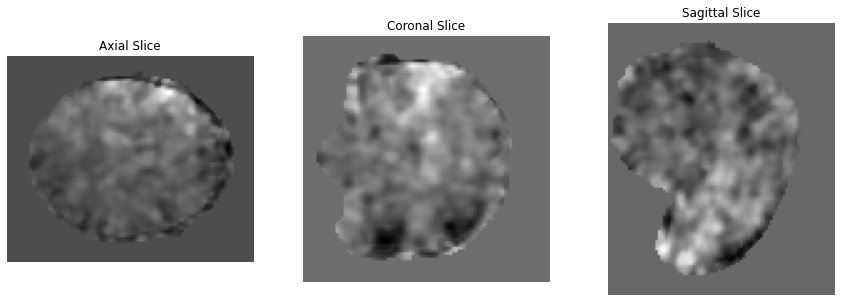

In [9]:
selected_ic = ic_extract(sica['melodic_IC'],sic_candidate)
plot_3d(selected_ic)

In [10]:
def calculate_lateralization_index_from_IC(IC_matrix):
# Ensure the input is of the correct shape
    if IC_matrix.shape != (91, 109, 91):
        raise ValueError("IC_matrix must be of shape (91, 109, 91)")

    # Define the ACPC plane (mid-sagittal plane)
    mid_plane_index = 45  # This is the zero-based index for the mid-sagittal plane

    left_voxels = []
    right_voxels = []
    
    # Extract mirroring voxels from both sides of the brain
    for x in range(mid_plane_index):
        mirrored_x = IC_matrix.shape[0] - 1 - x  # Find the mirroring voxel
        left_voxels.append(IC_matrix[x, :, :])
        right_voxels.append(IC_matrix[mirrored_x, :, :])
    
    # Flatten the voxel arrays
    left_voxels = np.array(left_voxels).flatten()
    right_voxels = np.array(right_voxels).flatten()
    
    # Calculate Pearson's correlation coefficient (symmetricity)
    correlation, _ = pearsonr(left_voxels, right_voxels)
    
    # Calculate mean and standard deviation of symmetricity
    symmetricities = [correlation]  # In a more complex scenario, you might have multiple ICs
    mean_symmetricity = np.mean(symmetricities)
    std_symmetricity = np.std(symmetricities)
    
    # Determine cut-off for symmetricity
    cutoff = mean_symmetricity - std_symmetricity
    
    # Filter out components with symmetricity greater than the cut-off
    if correlation <= cutoff:
        # Calculate Lateralization Index (LI)
        LI = 1-np.abs(correlation)
        # LI = (np.sum(left_voxels) - np.sum(right_voxels)) / (np.sum(left_voxels) + np.sum(right_voxels))
        return {"Lateralization Index": LI, "Symmetricity": correlation}
    else:
        return {"Lateralization Index": None, "Symmetricity": correlation}

LI_result = calculate_lateralization_index_from_IC(selected_ic)
print("Lateralization Index:", LI_result["Lateralization Index"])
print("Symmetricity:", LI_result["Symmetricity"])

Lateralization Index: 0.7562966717312359
Symmetricity: 0.24370332826876406



criterion indices: [(46, 19, 40)]
XYZ coordinates:   [(45, 20, 41)]
MNI coordinates:   [(-2.0, -88.0, 8.0)]


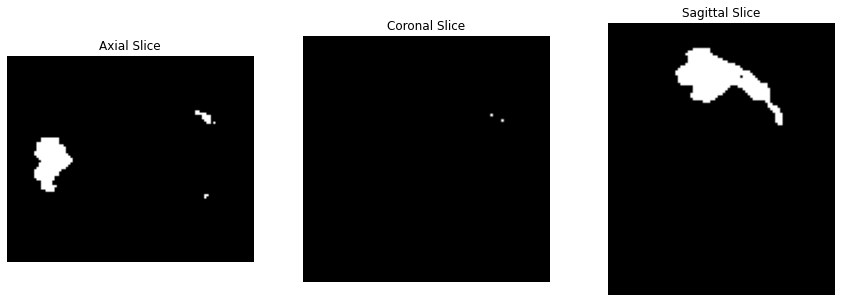

In [6]:
indices, selected_ic_cluster = ic_browse(selected_ic = selected_ic,
                                         criterion   = selected_ic >= 3.1,
                                         affine      = sica['melodic_IC'].affine,
                                         show        = False)

max_value, _ = ic_browse(selected_ic = selected_ic,
                         criterion   = selected_ic >= selected_ic.max(),
                         affine      = sica['melodic_IC'].affine,
                         show        = True)

plot_3d(selected_ic_cluster)

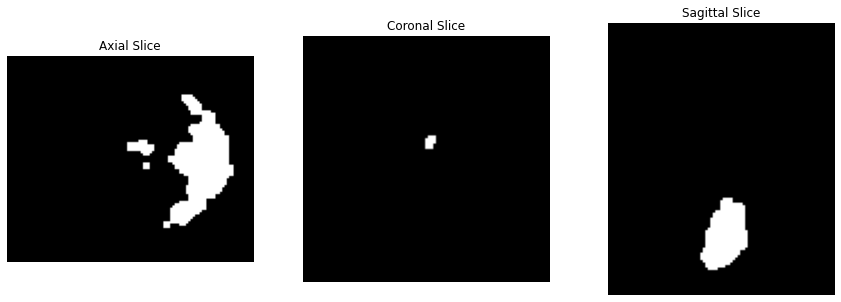

In [22]:
selected_ic_cluster = morphological_operation(selected_ic_cluster)
plot_3d(selected_ic_cluster)

In [23]:
np.sum(selected_ic_cluster)

11311

In [24]:
BLI_result = binary_lateralization(selected_ic_cluster)
BLI_result

{'Left Binary Lateralization': 0.275,
 'Right Binary Lateralization': 0.194,
 'Lateralization Strength': 0.171,
 'Side': 'Left'}

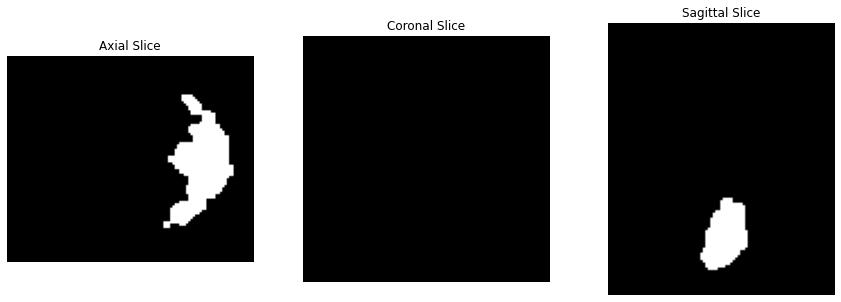

In [25]:
selected_ic_mask = mask_cc_around_coordinate(selected_ic_cluster, max_value["Max_index"][0])
plot_3d(selected_ic_mask)

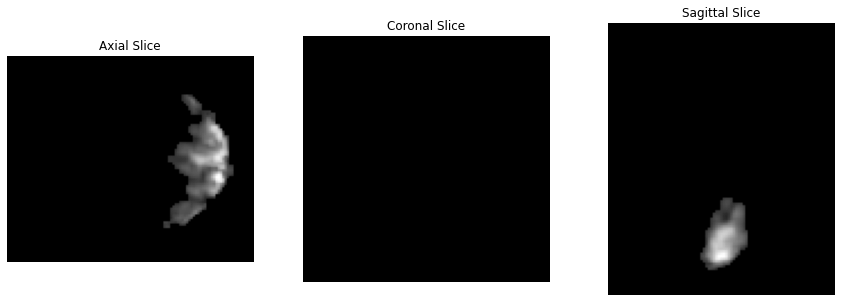

In [26]:
selected_ic_masked = selected_ic_mask * selected_ic
plot_3d(selected_ic_masked)

In [28]:
fmri_data = bold['filtered_func_data'].get_fdata()
ic_mask = selected_ic_mask
ic_fmri = fmri_data[ic_mask > 0]
ic_fmri.shape

(11010, 320)

In [29]:
central_energy = ic_central_energy(fmri_data, max_value["Max_index"][0])
central_energy

218223660429.39374

In [30]:
top_ics, kurtosis_values = tICA_on_sIC(ic_fmri, n_components=30)
kurtosis_values[0]
# for i, (ic, kurt_value) in enumerate(zip(top_ics, kurtosis_values), 1):
#     print(f"IC {i}: Kurtosis = {kurt_value}")

c:\Users\Mostafa\anaconda3\envs\neuroimaging\lib\site-packages\sklearn\decomposition\_fastica.py:519: UserWarning: n_components is too large: it will be set to 320
  warnings.warn(


315.00313234133415

In [21]:
downsample_factor = floor((np.sum(selected_ic_mask)/32)**(1/3))
downsample_factor

6

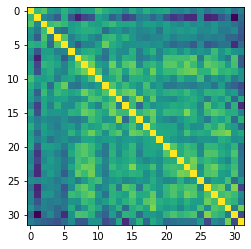

In [22]:
def cluster_connectivity_ds(fmri_data, mask, downsample_factor=2):
    if isinstance(downsample_factor, int):
        downsample_factor = (downsample_factor, downsample_factor, downsample_factor)
    downsampled_fmri = zoom(fmri_data, zoom=(1/downsample_factor[0], 1/downsample_factor[1], 1/downsample_factor[2], 1), order=1)
    downsampled_mask = zoom(mask, zoom=(1/downsample_factor[0], 1/downsample_factor[1], 1/downsample_factor[2]), order=0)
    masked_voxels = downsampled_fmri[downsampled_mask > 0]
    time_series = masked_voxels.T
    connectivity_matrix = np.corrcoef(time_series.T)    
    return connectivity_matrix

downsample_factor = floor((np.sum(selected_ic_mask)/32)**(1/3))
connectivity_matrix = cluster_connectivity_ds(bold['filtered_func_data'].get_fdata(), selected_ic_mask, downsample_factor)
plt.imshow(connectivity_matrix)

In [31]:
def voxel_network_strength(fmri_data, mask, voxel_index):
    if mask[voxel_index] == 0:
        raise ValueError("The specified voxel_index is not within the masked region.")
    time_series = fmri_data[mask > 0].T
    voxel_time_series = fmri_data[voxel_index].flatten()
    num_voxels = time_series.shape[1]
    network = np.zeros(num_voxels)
    for i in range(num_voxels):
        network[i] = np.abs(np.corrcoef(time_series[:, i], voxel_time_series)[0, 1])
    network = np.sort(network)[::-1]
    network_strength = round(sum(network)/num_voxels,3)
    return network_strength

central_network_strength = voxel_network_strength(bold['filtered_func_data'].get_fdata(), selected_ic_mask, max_value["Max_index"][0])
print("Central Network Strength:",central_network_strength)

Central Network Strength: 0.482


# Topological Measures

In [17]:
def calculate_clustering_coefficients(connectivity_matrix, random_matrices):
    G = nx.from_numpy_array(connectivity_matrix)
    local_clustering = clustering_coef_bu(connectivity_matrix)
    absolute_clustering_coefficient = np.mean(local_clustering)
    random_clustering_coeffs = []
    for random_matrix in random_matrices:
        random_clustering = clustering_coef_bu(random_matrix)
        random_clustering_coeffs.append(np.mean(random_clustering))
    Crandom = np.mean(random_clustering_coeffs)
    normalized_clustering_coefficient = absolute_clustering_coefficient / Crandom
    return absolute_clustering_coefficient, normalized_clustering_coefficient

def calculate_characteristic_path_length(connectivity_matrix, random_matrices):
    D = distance_bin(connectivity_matrix)
    L = np.mean(D[np.isfinite(D)])
    random_path_lengths = []
    for random_matrix in random_matrices:
        D_random = distance_bin(random_matrix)
        L_random = np.mean(D_random[np.isfinite(D_random)])
        random_path_lengths.append(L_random)
    Lrandom = np.mean(random_path_lengths)
    normalized_path_length = L / Lrandom
    return L, normalized_path_length

def calculate_small_world_index(gamma, lambda_):
    sigma = gamma / lambda_
    return sigma

def calculate_efficiency_measures(connectivity_matrix):
    local_efficiency = np.mean(efficiency_bin(connectivity_matrix, local=True))
    global_efficiency = efficiency_bin(connectivity_matrix, local=False)
    return local_efficiency, global_efficiency

def calculate_connectivity_strength(connectivity_matrix):
    strength = np.mean(connectivity_matrix[np.triu_indices_from(connectivity_matrix, k=1)])
    return strength

def calculate_connectivity_diversity(connectivity_matrix):
    N = connectivity_matrix.shape[0]
    mean_pairwise_correlations = np.mean(connectivity_matrix, axis=1)
    connectivity_diversity = np.var(connectivity_matrix - mean_pairwise_correlations[:, None], axis=1)
    average_connectivity_diversity = np.mean(connectivity_diversity)
    return average_connectivity_diversity

def calculate_betweenness_centrality(connectivity_matrix, hippocampal_nodes):
    G = nx.from_numpy_array(connectivity_matrix)
    betweenness = nx.betweenness_centrality(G, normalized=True)
    bc_left = betweenness[hippocampal_nodes['LH']]
    bc_right = betweenness[hippocampal_nodes['RH']]
    return bc_left, bc_right

def compute_topological_measures(connectivity_matrix, random_matrices, hippocampal_nodes):
    # 1. Clustering Coefficients
    C, gamma = calculate_clustering_coefficients(connectivity_matrix, random_matrices)
    
    # 2. Characteristic Path Length
    L, lambda_ = calculate_characteristic_path_length(connectivity_matrix, random_matrices)
    
    # 3. Small-World Index
    sigma = calculate_small_world_index(gamma, lambda_)
    
    # 4. Efficiency Measures
    local_efficiency, global_efficiency = calculate_efficiency_measures(connectivity_matrix)
    
    # 5. Connectivity Strength
    CS = calculate_connectivity_strength(connectivity_matrix)
    
    # 6. Connectivity Diversity
    CD = calculate_connectivity_diversity(connectivity_matrix)
    
    # 7. Betweenness Centrality
    bc_left, bc_right = calculate_betweenness_centrality(connectivity_matrix, hippocampal_nodes)
    
    return {
        'Clustering Coefficient': round(C,3),
        # 'Normalized Clustering Coefficient (gamma)': round(gamma,3),
        'Characteristic Path Length': round(L,3),
        # 'Normalized Characteristic Path Length (lambda)': round(lambda_,3),
        # 'Small-World Index (sigma)': round(sigma,3),
        'Local Efficiency': round(local_efficiency,3),
        # 'Global Efficiency': round(global_efficiency,3),
        'Connectivity Strength': round(CS,3),
        'Connectivity Diversity': round(CD,3),
        # 'Betweenness Centrality (Left Hippocampus)': round(bc_left,3),
        # 'Betweenness Centrality (Right Hippocampus)': round(bc_right,3),
    }


In [18]:
def generate_random_matrices(connectivity_matrix, num_random_matrices=500):
    random_matrices = []
    for _ in range(num_random_matrices):
        random_matrix = np.random.permutation(connectivity_matrix.flatten()).reshape(connectivity_matrix.shape)
        random_matrices.append(random_matrix)
    return random_matrices

In [19]:
random_matrices = generate_random_matrices(connectivity_matrix, num_random_matrices=500)
hippocampal_nodes = {'LH': 0, 'RH': 1}  # Indices for left and right hippocampus
TM_result = compute_topological_measures(connectivity_matrix, random_matrices, hippocampal_nodes)
for measure, value in TM_result.items():
    print(f"{measure}: {value}")

Clustering Coefficient: 0.703
Characteristic Path Length: 0.995
Local Efficiency: 1.0
Connectivity Strength: 0.698
Connectivity Diversity: 0.022


In [20]:
max_value_fmri = fmri_data[max_value["Max_index"][0]]
max_area_fmri = mean_fmri_in_neighborhood(fmri_data, max_value["Max_index"][0], 3)
R_outside_inside = outside_inside_ratio(selected_ic, sica['mask'])
max_power_freq = max_power_frequency(max_area_fmri, tr=3.0)

In [19]:
sIC_Features = {
    'Subject ID': subject_id,
    'sIC Number': sic_candidate,
    'sIC Center': max_value['MNI_coords'],
    'Lateralization Index': LI_result['Lateralization Index'],
    'Lateralization Strength': BLI_result['Lateralization Strength'],
    'Lateralization Side': BLI_result['Side'],
    'Centeral Network': central_network_strength,
    'Clustering Coefficient': TM_result['Clustering Coefficient'],
    'Characteristic Path Length': TM_result['Characteristic Path Length'],
    'Local Efficiency': TM_result['Local Efficiency'],
    'Connectivity Strength': TM_result['Connectivity Strength'],
    'Connectivity Diversity': TM_result['Connectivity Diversity'],  
}

df = pd.DataFrame(sIC_Features, index=[0])
results_path = 'results/sIC_Candidate_Feature.csv'

if os.path.isfile(results_path):
    df.to_csv(results_path, mode='a', index=False, header=False)
else:
    df.to_csv(results_path, index=False, header=True)